In [91]:
import pandas as pd
import numpy as np
import os 
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, silhouette_score, classification_report
import category_encoders as ce
from sklearn.decomposition import PCA
from JPMC_LIB import JPMC_LIB as jpmc_lib
from mpl_toolkits.mplot3d import Axes3D

In [2]:
file1 = r"C:\Users\thema\OneDrive\Projects\JPMC_Fraud_Analysis\data\fraudTrain.csv"
file2 = r"C:\Users\thema\OneDrive\Projects\JPMC_Fraud_Analysis\data\fraudTest.csv"


df1=pd.read_csv(file1)
df2=pd.read_csv(file2)


In [3]:
df1['id'] = 'train'
df2['id'] = 'test'

In [4]:
df = pd.concat([df1, df2], axis = 0)

In [5]:
df.shape

(1852394, 24)

In [6]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,id
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,train
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,train
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,train
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,train
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,train


In [7]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [8]:
info_df = pd.DataFrame({'nulls': df.isnull().sum(), 'dtypes': df.dtypes})
info_df

,nulls,dtypes
trans_date_trans_time,0,object
cc_num,0,int64
merchant,0,object
category,0,object
amt,0,float64
first,0,object
last,0,object
gender,0,object
street,0,object
city,0,object


In [9]:
duplicates = df.duplicated().sum()
duplicates

0

In [10]:
# Convert string datetime to pandas datetime format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Extract year, month, day, hour, minute, and second as separate columns
df['year'] = df['trans_date_trans_time'].dt.year
df['month'] = df['trans_date_trans_time'].dt.month
df['day'] = df['trans_date_trans_time'].dt.dayofweek
df['hour'] = df['trans_date_trans_time'].dt.hour
df['minute'] = df['trans_date_trans_time'].dt.minute
df['second'] = df['trans_date_trans_time'].dt.second

# Drop the original datetime column


In [11]:
# New age collumn for each person according to transaction

df['dob'] = pd.to_datetime(df['dob'])
df['age']=df['year'] - df['dob'].dt.year

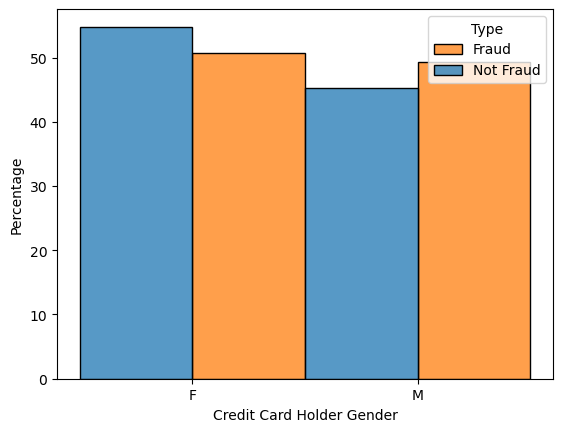

In [12]:
#Gender vs Fraud
jpmc_lib.plot_gender_fraud_relationship(df)

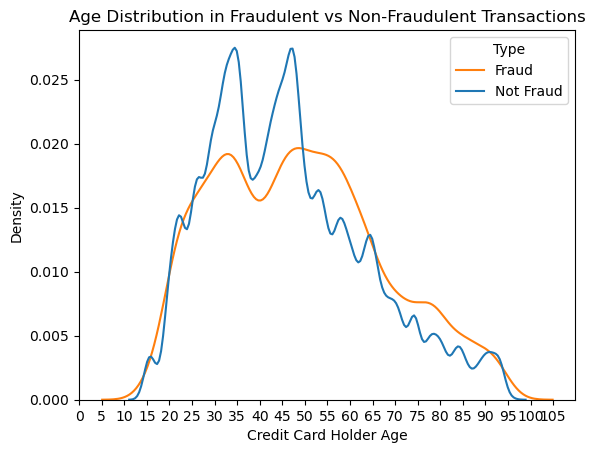

In [13]:
#age vs fraud
jpmc_lib.plot_age_distribution(df)

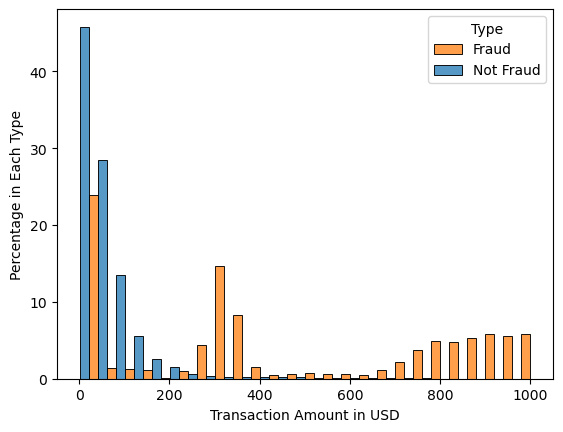

In [14]:
#amount vs fraud
jpmc_lib.plot_transaction_amount_distribution(df)

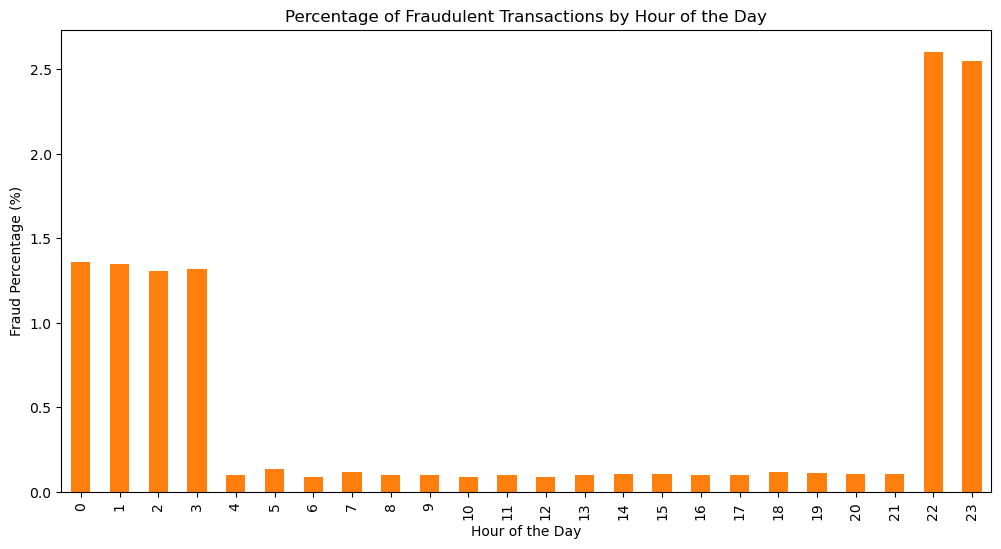

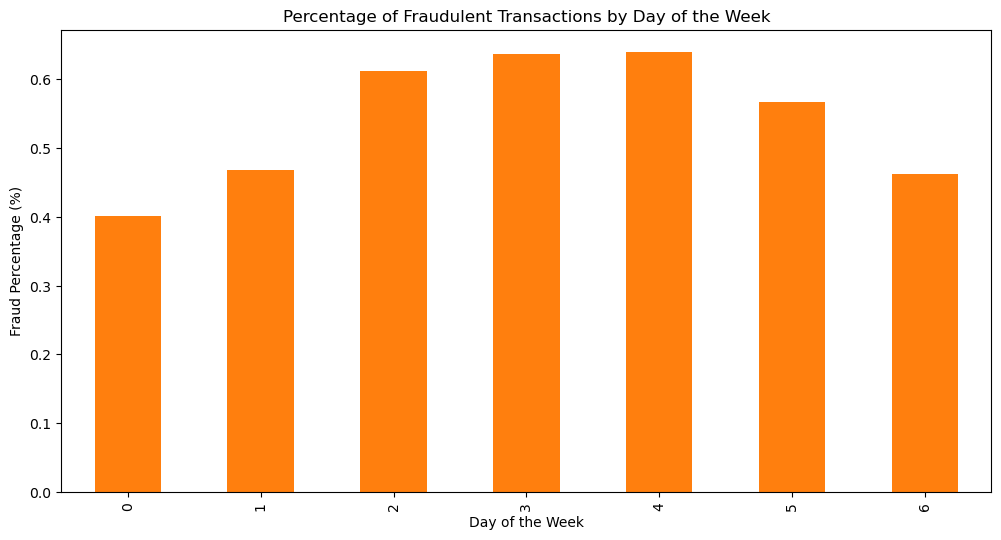

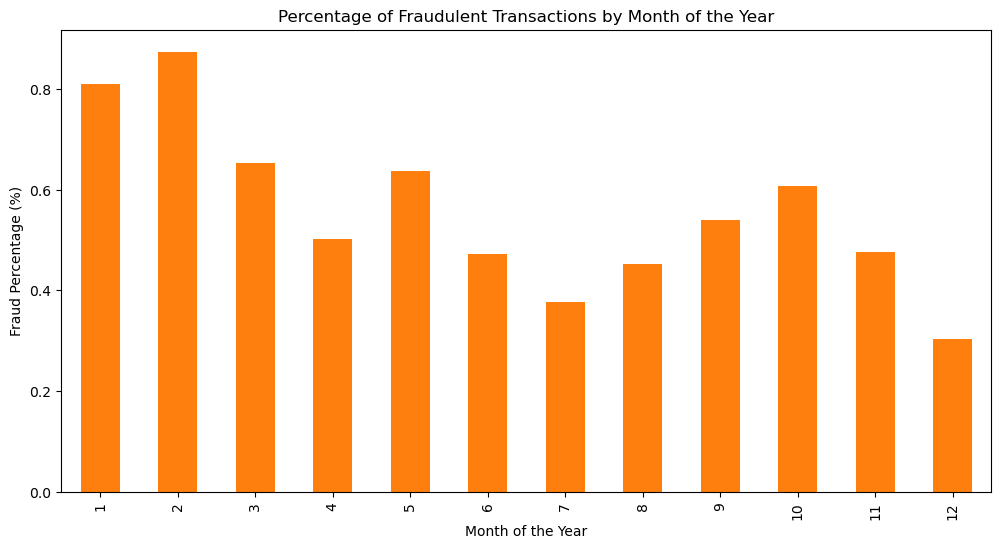

In [15]:
#group by hours of the day
group_by_hour = df.groupby('hour')['is_fraud'].agg(['count', 'sum']).rename(columns={'count': 'Total', 'sum': 'Fraud'})
jpmc_lib.plot_fraud_percentage_bytime(group_by_hour, 'Percentage of Fraudulent Transactions by Hour of the Day', 'Hour of the Day')

# Group by day of the week
group_by_day = df.groupby('day')['is_fraud'].agg(['count', 'sum']).rename(columns={'count': 'Total', 'sum': 'Fraud'}) 
jpmc_lib.plot_fraud_percentage_bytime(group_by_day, 'Percentage of Fraudulent Transactions by Day of the Week', 'Day of the Week')

# Group by month of the year
group_by_month = df.groupby('month')['is_fraud'].agg(['count', 'sum']).rename(columns={'count': 'Total', 'sum': 'Fraud'}) 
jpmc_lib.plot_fraud_percentage_bytime(group_by_month, 'Percentage of Fraudulent Transactions by Month of the Year', 'Month of the Year')

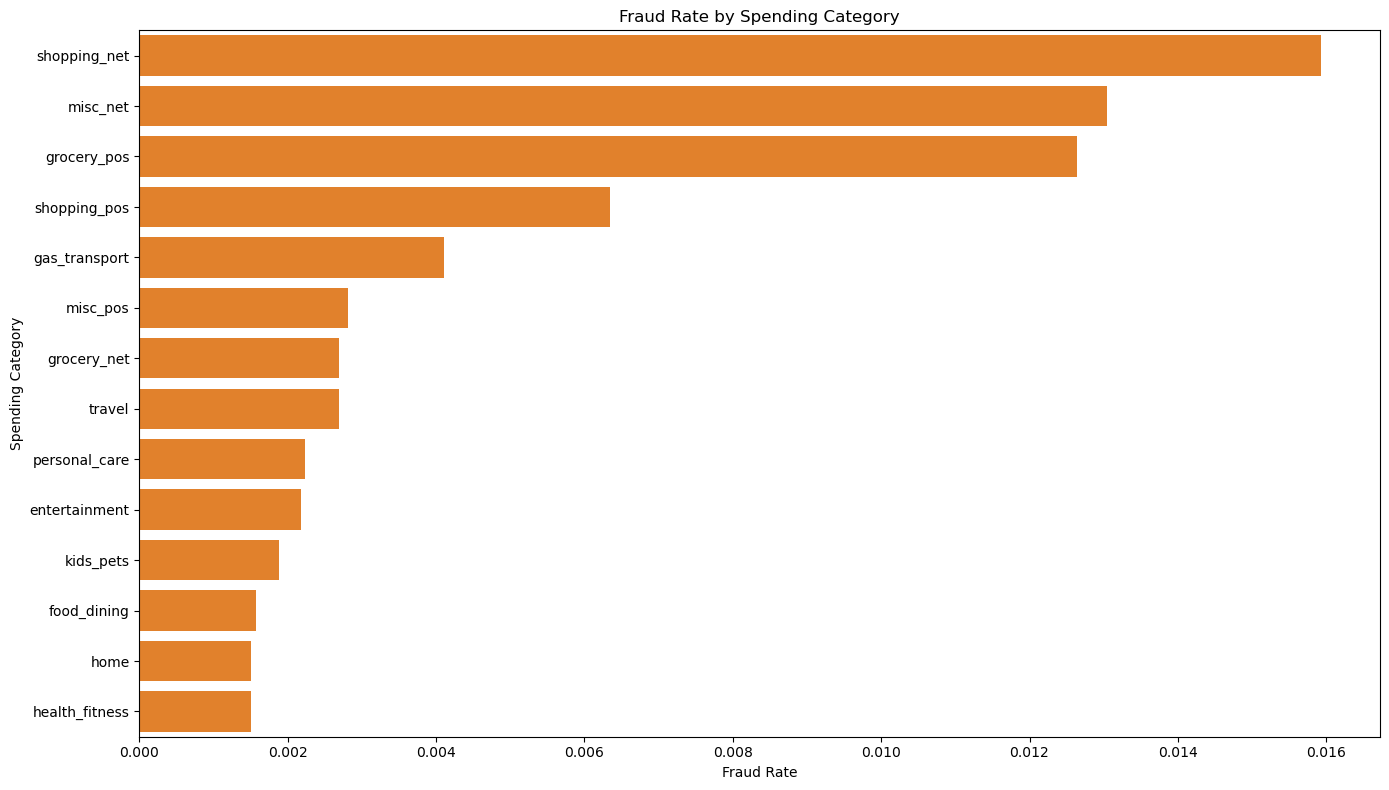

In [16]:
jpmc_lib.plot_fraud_rate_by_category(df)

In [17]:
woe = ce.WOEEncoder()
y = df['is_fraud']

In [18]:
X = df['category']
df['enc_category'] = woe.fit_transform(X,y)

In [19]:
X = df['state']
df['enc_state'] = woe.fit_transform(X,y)

In [20]:
freq_enc = (df.groupby("cc_num").size())
df['cc_frequency'] = df["cc_num"].apply(lambda x: freq_enc[x])

In [21]:
cc_nums = df['cc_num'].nunique()
people = (df['first'] + df['last']).nunique()

cc_nums, people

(999, 989)

In [22]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'id', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'age', 'enc_category', 'enc_state', 'cc_frequency'],
      dtype='object')

In [135]:
filtered_df = df.drop(columns = ['trans_date_trans_time', 'state', 'category', 'unix_time', 'cc_num','merchant','gender','street','city','job', 'dob', 'year', 'minute', 'second', 'trans_num', 'first', 'last', 'zip'])

In [24]:
filtered_df.head()

,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,id,month,day,hour,age,enc_category,enc_state,cc_frequency
0,4.97,28654,36.0788,-81.1781,3495,36.011293,-82.048315,0,train,1,1,0,31,0.925860,-0.137702,2927
1,107.23,99160,48.8878,-118.2105,149,49.159047,-118.186462,0,train,1,1,0,41,0.894448,-0.104509,4362
2,220.11,83252,42.1808,-112.2620,4154,43.150704,-112.154481,0,train,1,1,0,57,-0.872388,-0.209468,735
3,45.00,59632,46.2306,-112.1138,1939,47.034331,-112.561071,0,train,1,1,0,52,-0.238221,-0.225199,743
4,41.96,24433,38.4207,-79.4629,99,38.674999,-78.632459,0,train,1,1,0,33,-0.613751,0.231808,2922


In [136]:
Train_set = filtered_df[filtered_df['id'] == 'train']
Test_set = filtered_df[filtered_df['id'] == 'test']

Train_set.drop(columns= 'id', inplace = True)
Test_set.drop(columns= 'id', inplace = True)

In [137]:
X_scaled = pd.concat([Train_set, Test_set], axis = 0).drop(columns='is_fraud')
y_scaled = filtered_df['is_fraud']

In [138]:
X_scaled[X_scaled.columns] = StandardScaler().fit_transform(X_scaled)

0.3236818000602225


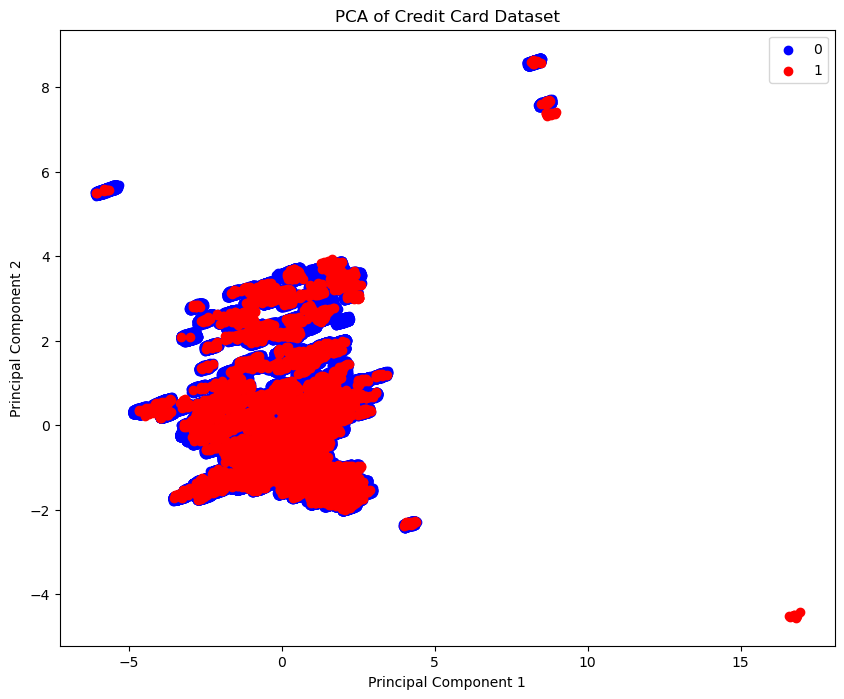

In [30]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
print(sum(pca.explained_variance_ratio_))
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add the 'is_fraud' column from your original dataset to the PCA DataFrame
pca_df['is_fraud'] = y_scaled

# Plotting
plt.figure(figsize=(10, 8))
for label, color in zip(pca_df['is_fraud'].unique(), ['blue', 'red']):
    # Filter the data based on the label and plot each group
    temp_df = pca_df[pca_df['is_fraud'] == label]
    plt.scatter(temp_df['PC1'], temp_df['PC2'], label=label, color=color)

plt.title('PCA of Credit Card Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [31]:
lower_limit_pc1 = 6
upper_limit_pc1 = 10
lower_limit_pc2 = 6
upper_limit_pc2 = 8

# Define the range of the outlier region in PC1 and PC2
pc1_range = (lower_limit_pc1, upper_limit_pc1)
pc2_range = (lower_limit_pc2, upper_limit_pc2)

# Filter the data
outlier_data = pca_df[(pca_df['PC1'] >= pc1_range[0]) & (pca_df['PC1'] <= pc1_range[1]) & 
                      (pca_df['PC2'] >= pc2_range[0]) & (pca_df['PC2'] <= pc2_range[1])]

# Count the number of instances in each class within the outlier region
class_counts = outlier_data['is_fraud'].value_counts()

# Print the counts
print(class_counts)


is_fraud
0    531
1     21
Name: count, dtype: int64


Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

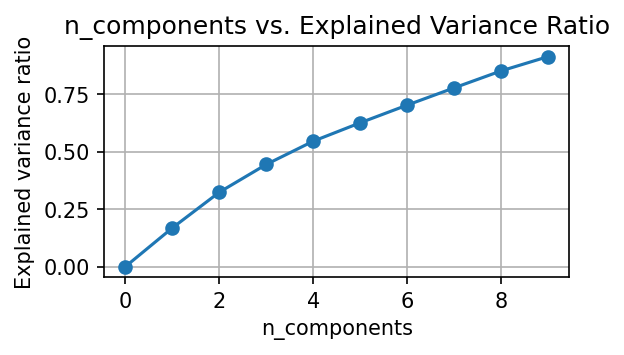

In [32]:
nums = np.arange(10)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(X_scaled)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [33]:
gmm = GaussianMixture(n_components=4, random_state=0)

# Fit the model
gmm.fit(X_scaled)

# Maximizing the log-likelihood
print("Log-Likelihood:", gmm.score(X_scaled))

# Calculate AIC and BIC
aic = gmm.aic(X_scaled)
bic = gmm.bic(X_scaled)

print("AIC:", aic)
print("BIC:", bic)

Log-Likelihood: -8.753706481893
AIC: 22702262.70481721
BIC: 22707322.261321884


In [ ]:
# Range of possible cluster numbers
cluster_range = range(1, 11)

# Lists to store AIC and BIC values
aics = []
bics = []

# Fit GMMs for different number of clusters
for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=0)
    gmm.fit(X)
    aics.append(gmm.aic(X_scaled))
    bics.append(gmm.bic(X_scaled))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, aics, label='AIC', marker='o')
plt.plot(cluster_range, bics, label='BIC', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC vs Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

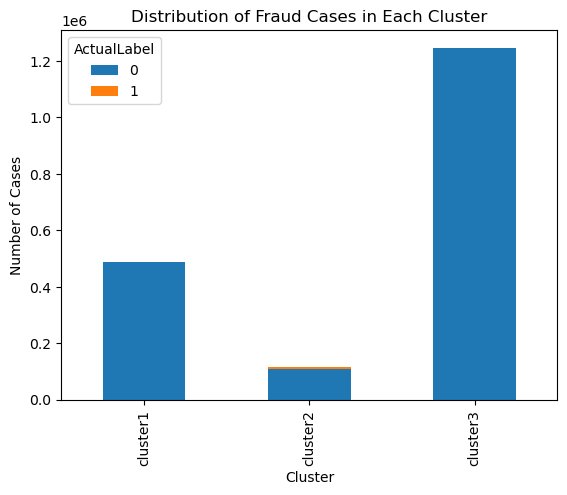

In [142]:
gmm = GaussianMixture(n_components=3, random_state=0)  # Adjust n_components as needed
gmm.fit(X_scaled)

clusters = gmm.predict(X_scaled)

weights = list(gmm.weights_)
cluster_labels = []
for i in range(1, len(weights)+1):
    cluster_labels.append(f'cluster{i}')
predicted_labels = [cluster_labels[cluster] for cluster in clusters]

# Create a DataFrame with actual and predicted labels
cluster_df = pd.DataFrame({'ActualLabel': y_scaled, 'ClusterLabel': predicted_labels})

cluster_fraud_distribution = cluster_df.groupby('ClusterLabel')['ActualLabel'].value_counts().unstack()

cluster_fraud_distribution.plot(kind='bar', stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Number of Cases')
plt.title('Distribution of Fraud Cases in Each Cluster')
plt.show()

In [143]:
jpmc_lib.cluster_summary(cluster_df, 2)

ActualLabel
0    109365
1      7032
Name: count, dtype: int64

Percentage of total fraud cases in cluster2: 72.86%
Percentage of fraud cases to non fraud cases in cluster2: 6.43%


In [157]:
X_scaled['ClusterLabel'] = predicted_labels
X_scaled['ActualLabel'] = y_scaled.reset_index(drop=True)

cluster2_X = X_scaled[X_scaled['ClusterLabel'] == 'cluster2']
cluster1_3_X = X_scaled[X_scaled['ClusterLabel'].isin(['cluster1', 'cluster3'])]

# Now, remove the 'ClusterLabel' and 'ActualLabel' from X_scaled to keep it as original
X_scaled.drop(columns=['ClusterLabel', 'ActualLabel'], inplace=True)
cluster2_y = cluster2_X['ActualLabel']
cluster2_X.drop(columns= ['ActualLabel', 'ClusterLabel'], inplace= True)

cluster1_3_y = cluster1_3_X['ActualLabel']
cluster1_3_X.drop(columns= ['ActualLabel', 'ClusterLabel'], inplace= True)


In [1]:
cluster2_X.shape[0] /X_scaled.shape[0]

NameError: name 'cluster2_X' is not defined

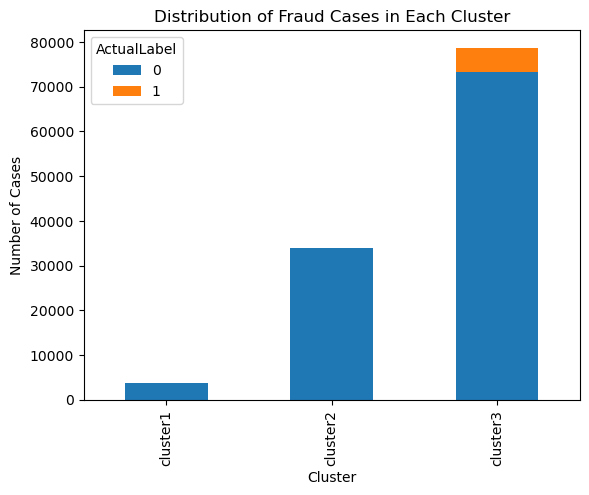

In [163]:
bgmm = BayesianGaussianMixture(n_components=3, random_state=0)  # Adjust n_components as needed
bgmm.fit(cluster2_X)

clusters = bgmm.predict(cluster2_X)

weights = list(bgmm.weights_)
cluster_labels = []
for i in range(1, len(weights)+1):
    cluster_labels.append(f'cluster{i}')
predicted_labels = [cluster_labels[cluster] for cluster in clusters]

# Create a DataFrame with actual and predicted labels
cluster_df = pd.DataFrame({'ActualLabel': cluster2_y, 'ClusterLabel': predicted_labels})

cluster_fraud_distribution = cluster_df.groupby('ClusterLabel')['ActualLabel'].value_counts().unstack()

cluster_fraud_distribution.plot(kind='bar', stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Number of Cases')
plt.title('Distribution of Fraud Cases in Each Cluster')
plt.show()

In [164]:
jpmc_lib.cluster_summary(cluster_df, 3)

ActualLabel
0    73216
1     5488
Name: count, dtype: int64

Percentage of total fraud cases in cluster3: 97.05%
Percentage of fraud cases to non fraud cases in cluster3: 7.50%
